In [23]:
from collections import defaultdict
from hausdorff import hausdorff_distance
import math
import cv2
import numpy as np
import scipy 
import scipy.cluster.hierarchy as hcluster
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def load_image(path: str):
    return cv2.imread(path)


def show_image(img, title="") -> None:
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.show()

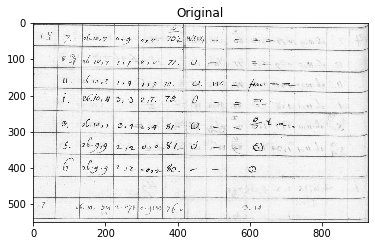

In [2]:
img_og = load_image('./assets/scan--no-borders.png')
img = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
show_image(img, "Original")

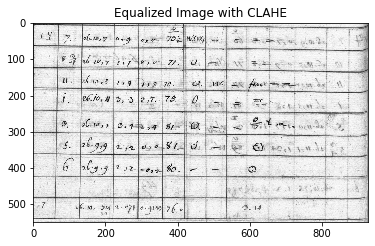

In [3]:
def equalize_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)


img_equalized = equalize_image(img.copy())
show_image(img_equalized, "Equalized Image with CLAHE")

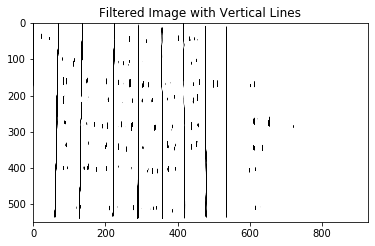

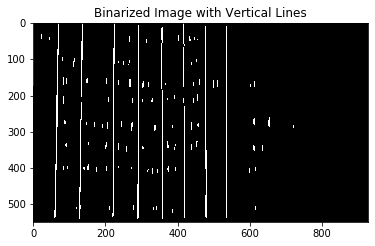

In [4]:
def binarize_image(img, otsu=True):
    img_binarized = None
    if otsu:
        threshold, img_binarized = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        threshold, img_binarized = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    return img_binarized


def _get_kernel(theta) -> float:
    ksize = 31
    return cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)

    
def filter_image(img, theta=np.pi):
    kernel = _get_kernel(theta)
    return cv2.filter2D(img, -1, kernel)


def invert(img):
    return cv2.bitwise_not(img)


img_filtered = filter_image(img, theta=np.pi)
show_image(img_filtered, "Filtered Image with Vertical Lines")

img_vertical_binarized = binarize_image(img_filtered.copy())
img_vertical_binarized = invert(img_vertical_binarized)
show_image(img_vertical_binarized, "Binarized Image with Vertical Lines")

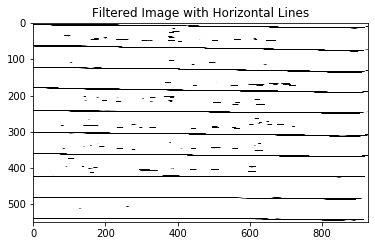

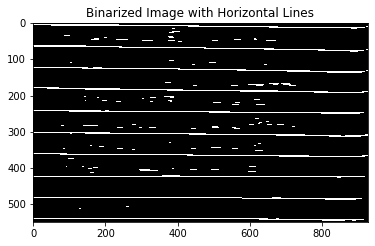

In [5]:
img_filtered = filter_image(img, theta=np.pi/2)
show_image(img_filtered, "Filtered Image with Horizontal Lines")

img_horizontal_binarized = binarize_image(img_filtered.copy())
img_horizontal_binarized = invert(img_horizontal_binarized)
show_image(img_horizontal_binarized, "Binarized Image with Horizontal Lines")

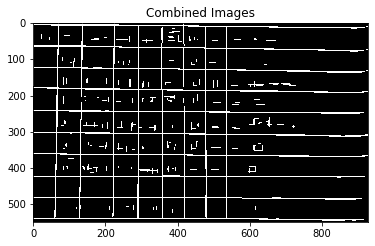

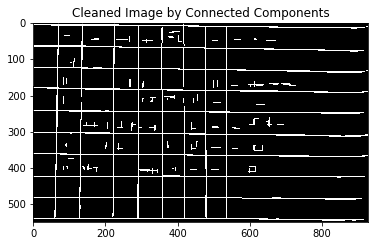

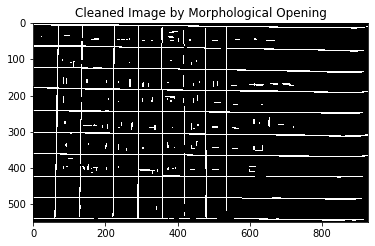

In [6]:
def moprhological_opening(img):
    kernel = np.ones((3,3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


def remove_connected_components(img, min_size=50):
    number_of_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)
    sizes = stats[1:, -1]  # first index represents the background and the last column the total area in pixels
    number_of_labels = number_of_labels - 1
     
    img_cleaned = np.full(img.shape, 0)
    for i in range(0, number_of_labels):
        if sizes[i] >= min_size:
            img_cleaned[labels == i + 1] = 255
        else:
            number_of_labels = number_of_labels - 1
            
    return img_cleaned


connected_components_threshold = 50

img_combined = cv2.bitwise_or(img_vertical_binarized, img_horizontal_binarized)
show_image(img_combined, "Combined Images")

img_cleaned_cc = remove_connected_components(img_combined.copy(), connected_components_threshold)
show_image(img_cleaned_cc, "Cleaned Image by Connected Components")

img_cleaned_morph = moprhological_opening(img_combined.copy())
show_image(img_cleaned_morph, "Cleaned Image by Morphological Opening")

The next step would be the extraction of connected components and the application of the hough transform on each connected component.
In Liang's thesis a connected component represents a single line, but this is not the case here. The whole table is recognized as a single component.


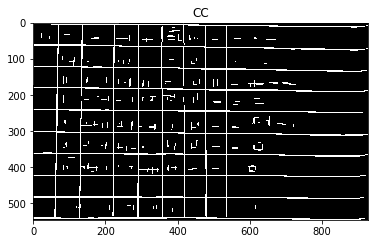

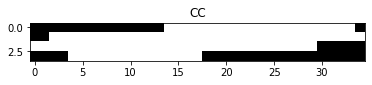

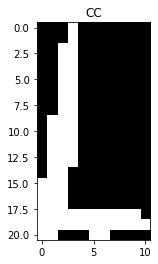

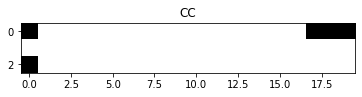

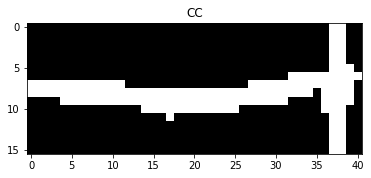

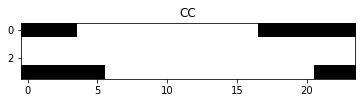

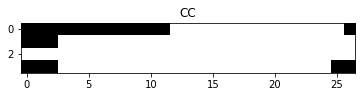

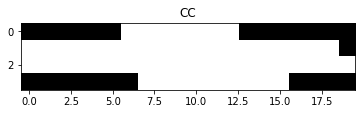

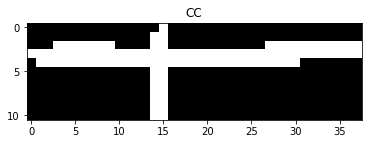

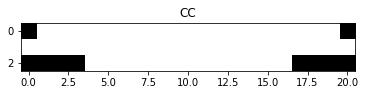

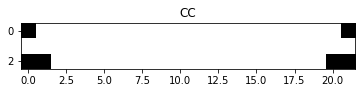

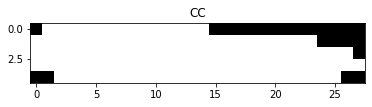

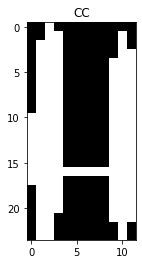

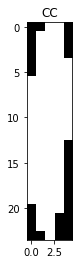

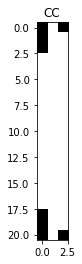

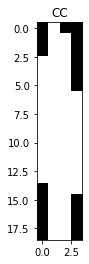

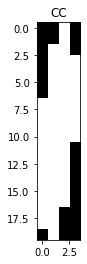

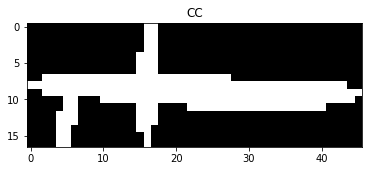

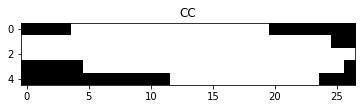

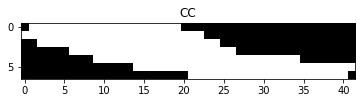

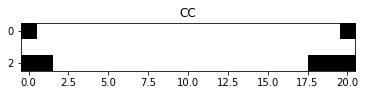

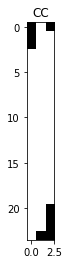

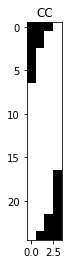

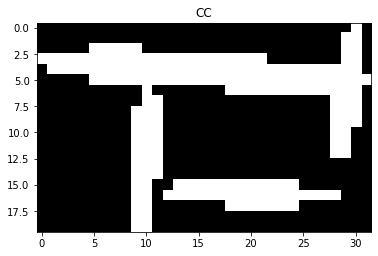

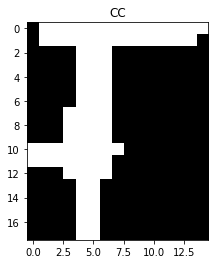

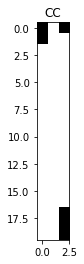

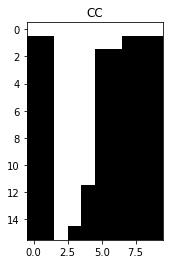

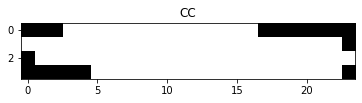

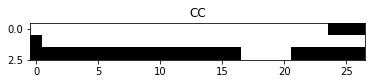

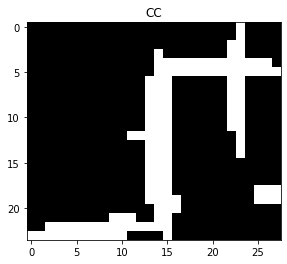

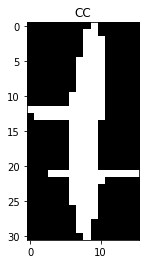

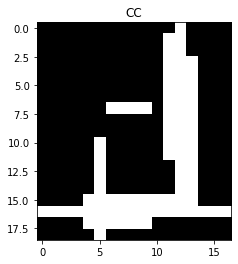

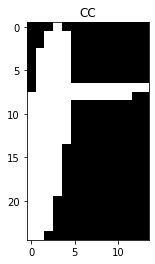

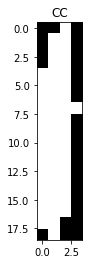

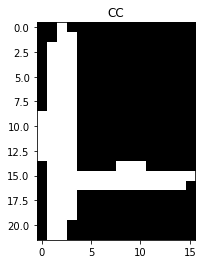

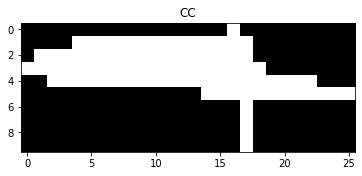

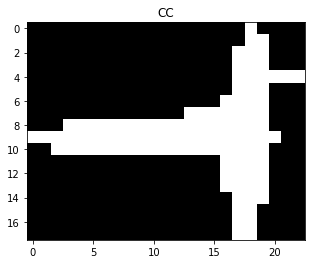

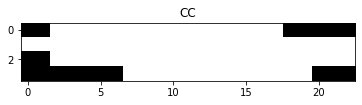

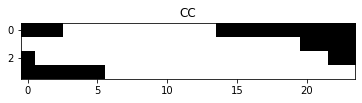

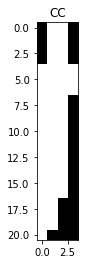

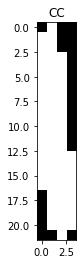

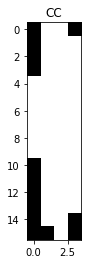

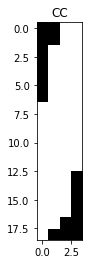

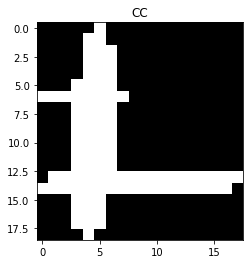

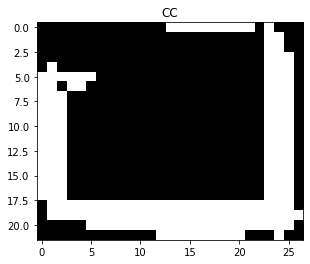

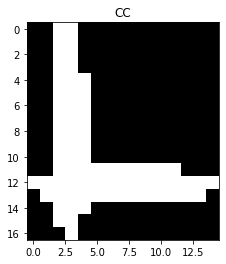

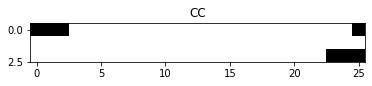

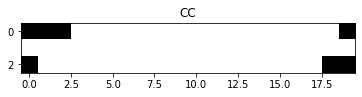

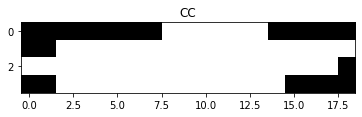

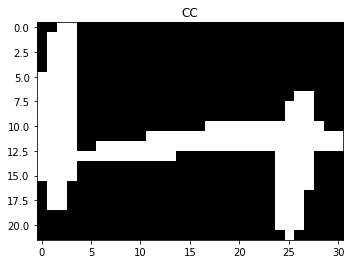

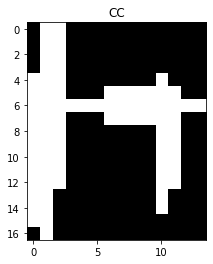

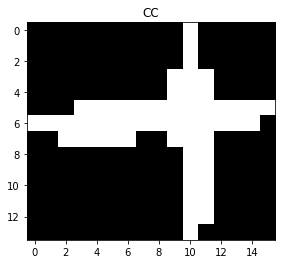

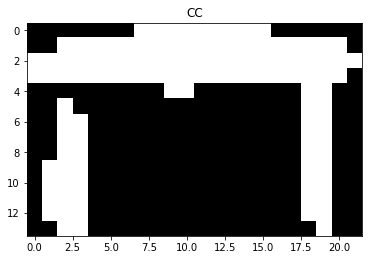

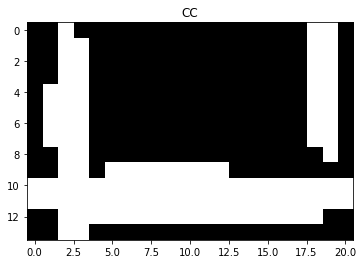

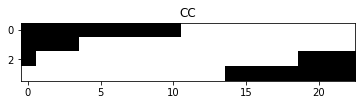

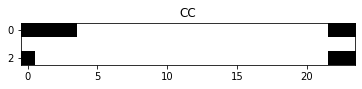

In [7]:
print("""The next step would be the extraction of connected components and the application of the hough transform on each connected component.
In Liang's thesis a connected component represents a single line, but this is not the case here. The whole table is recognized as a single component.""")

def apply_hough_transform(img, min_size=50):
    number_of_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)
    stats = stats[1:, :]  # first index represents the background, but we probably need all columns
    number_of_labels = number_of_labels - 1
    for i in range(0, number_of_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            cc_img = img[stats[i,cv2.CC_STAT_TOP]:stats[i,cv2.CC_STAT_TOP] + stats[i,cv2.CC_STAT_HEIGHT], \
                         stats[i,cv2.CC_STAT_LEFT]:stats[i,cv2.CC_STAT_LEFT] + stats[i,cv2.CC_STAT_WIDTH]]
            show_image(cc_img, "CC")
            
            
apply_hough_transform(img_combined.copy(), connected_components_threshold)

Another option would be the detection of contours as they could represent the table lines. But again, this is not the case.
Some table cells are detected but as you can see in the last image some cells are merged in one contour.


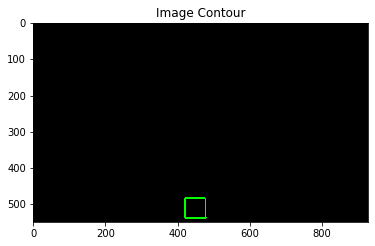

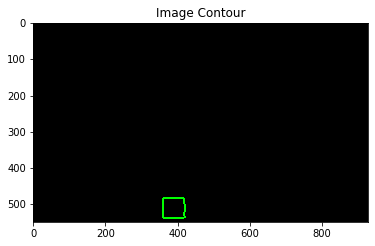

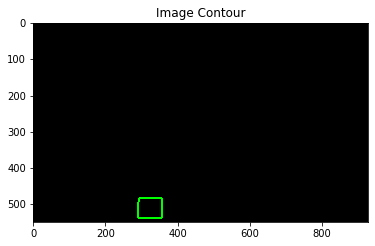

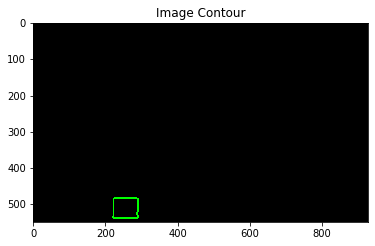

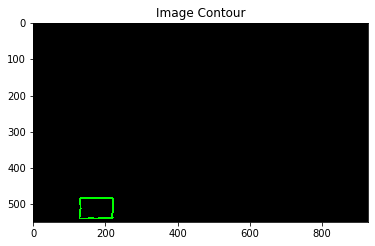

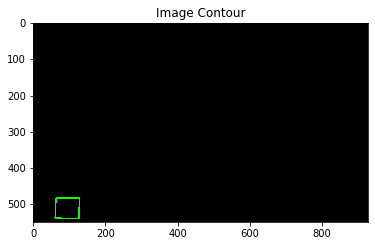

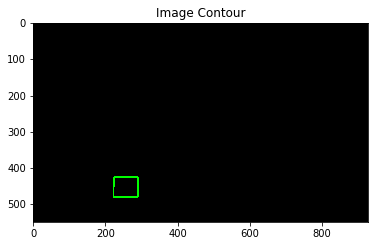

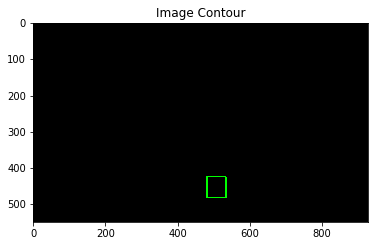

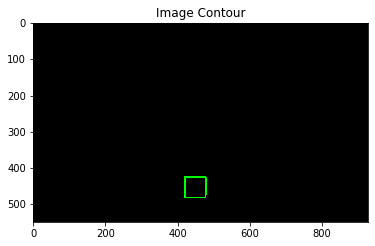

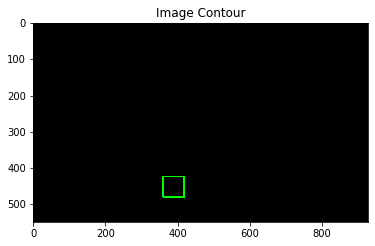

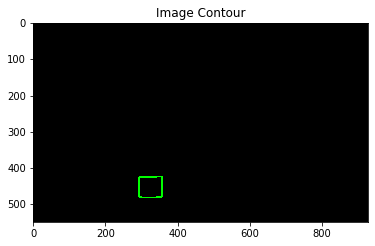

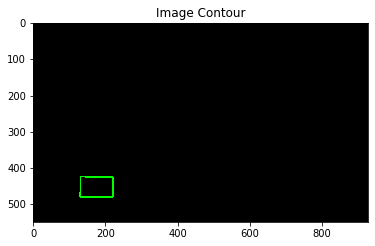

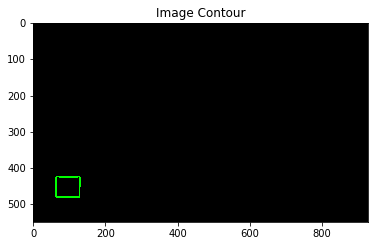

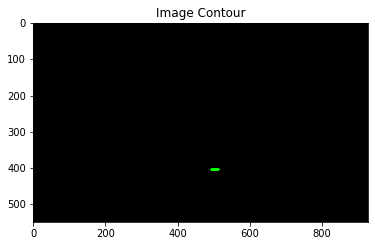

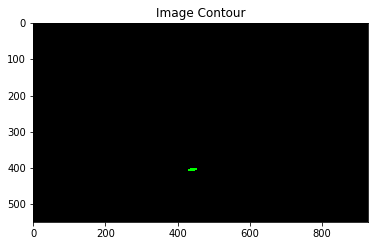

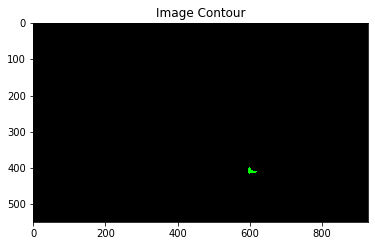

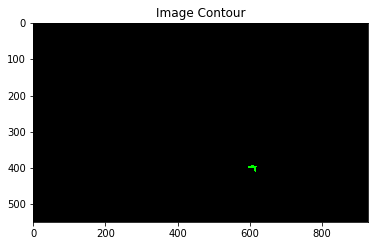

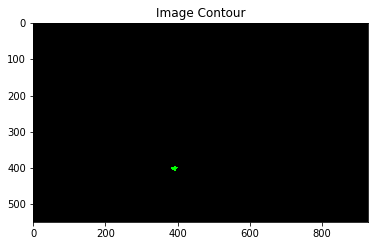

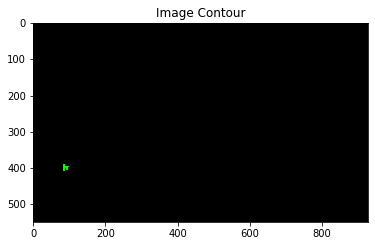

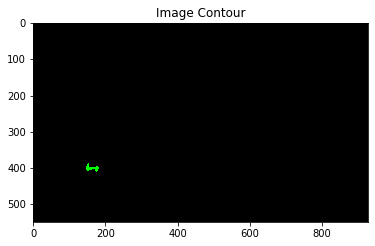

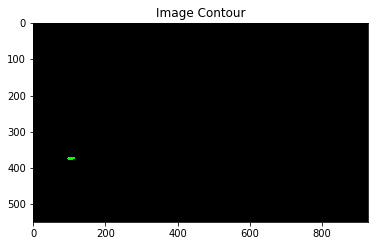

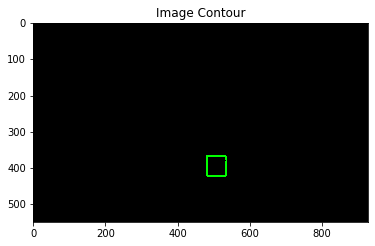

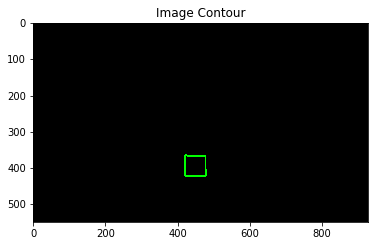

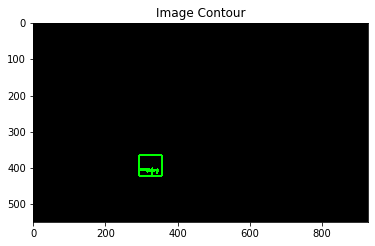

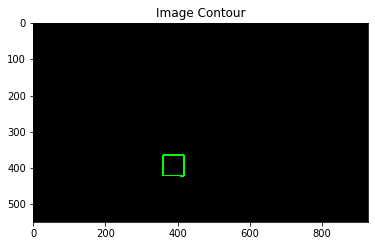

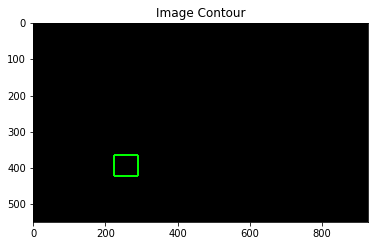

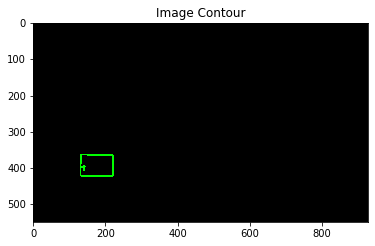

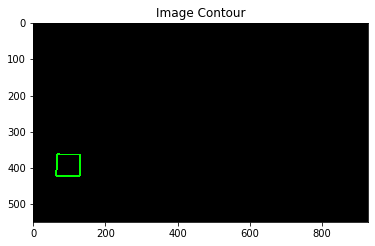

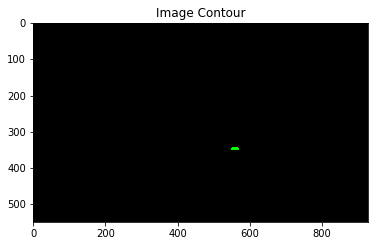

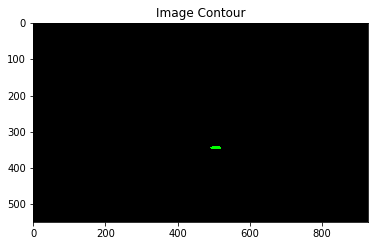

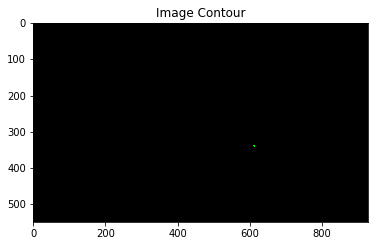

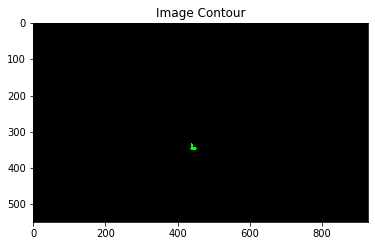

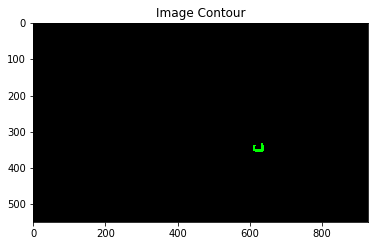

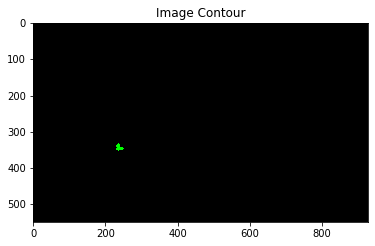

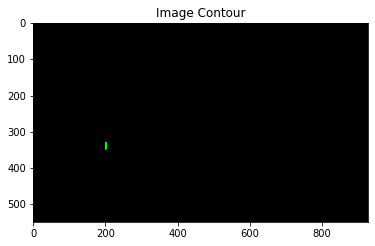

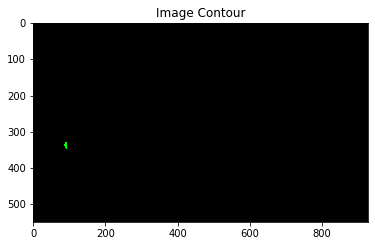

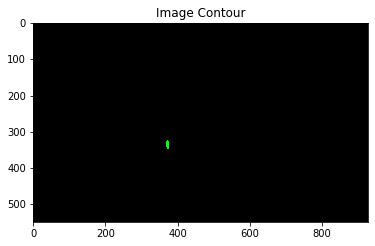

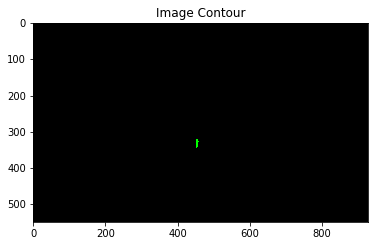

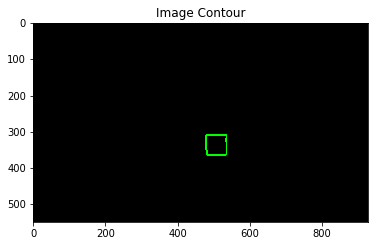

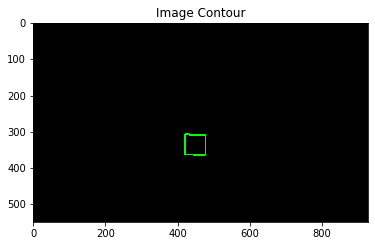

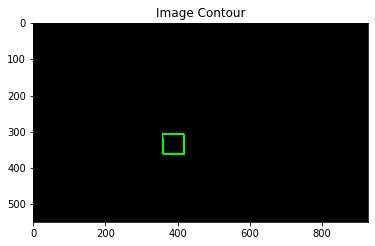

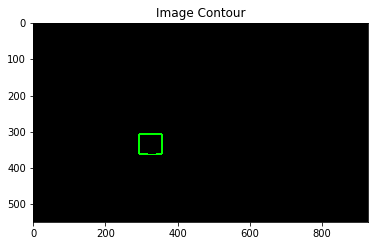

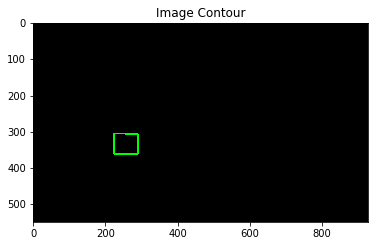

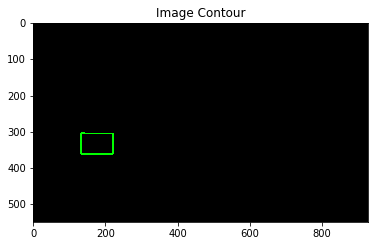

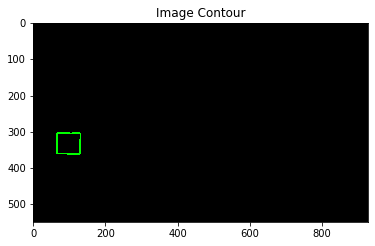

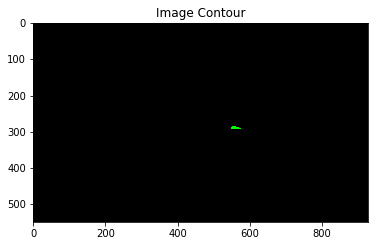

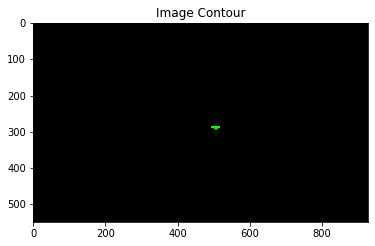

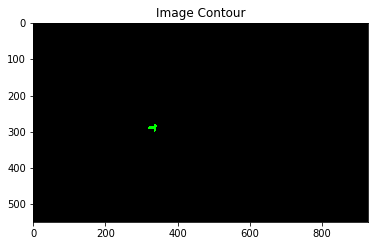

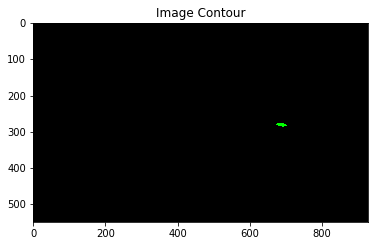

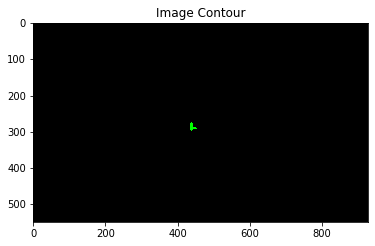

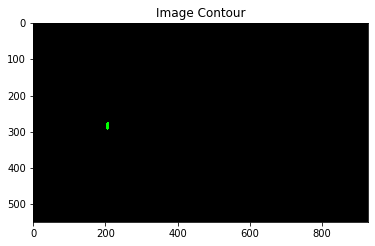

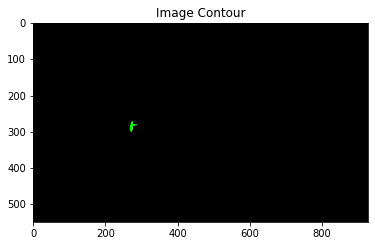

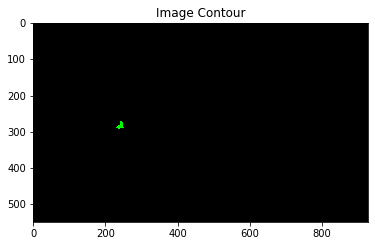

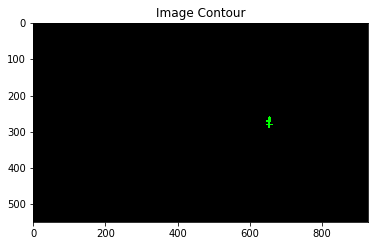

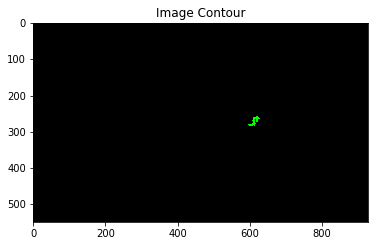

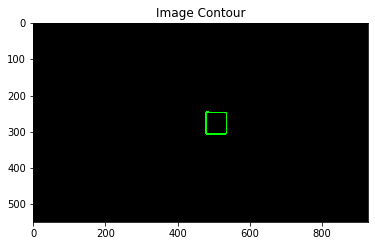

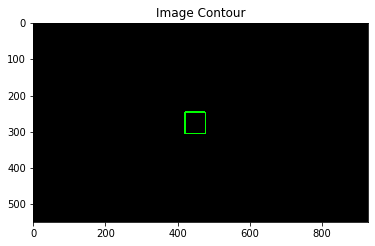

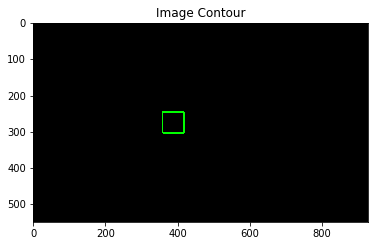

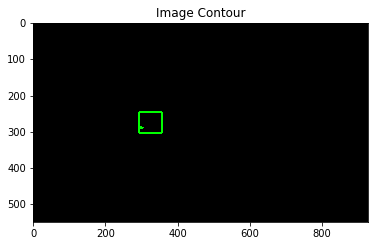

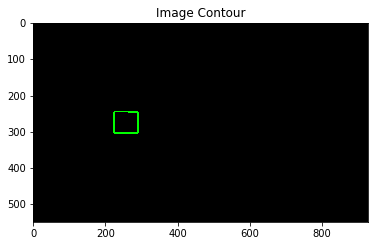

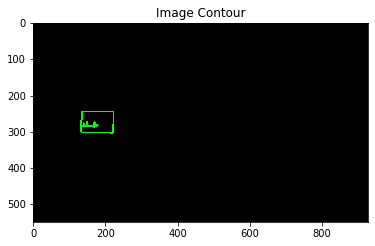

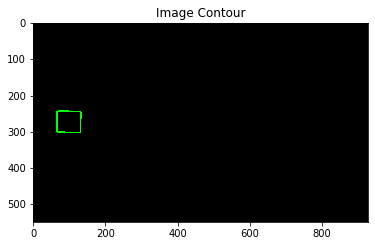

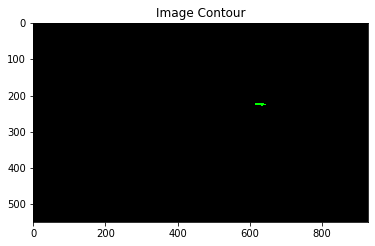

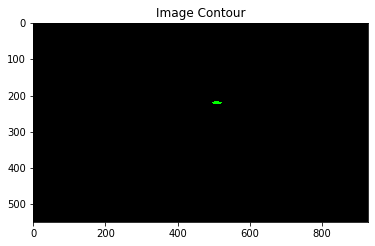

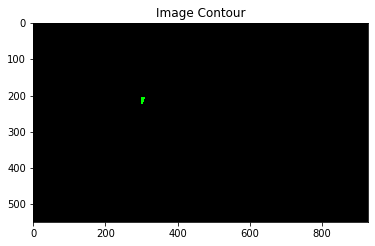

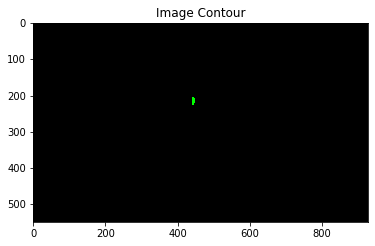

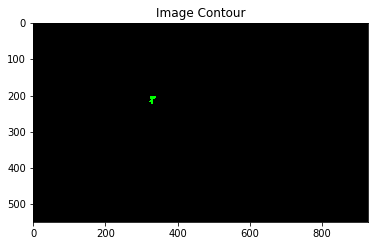

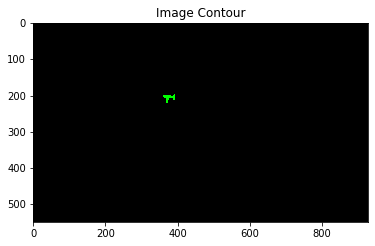

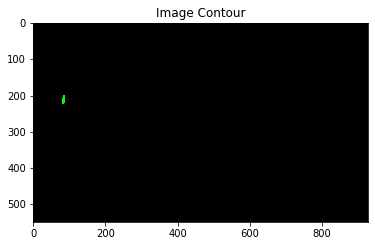

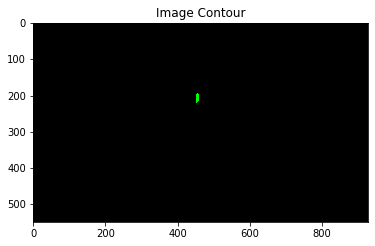

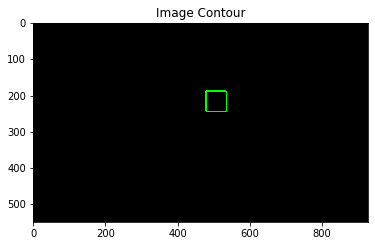

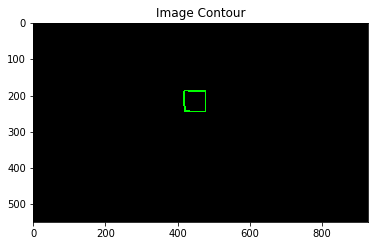

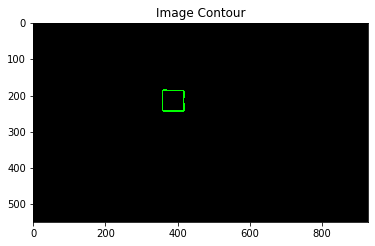

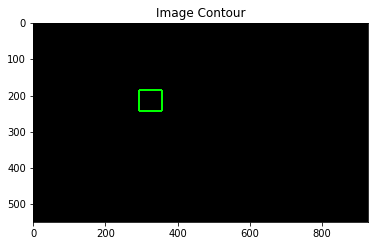

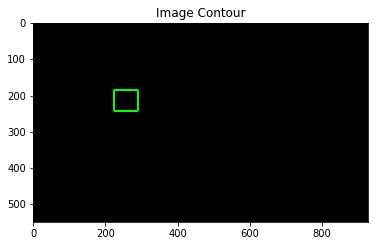

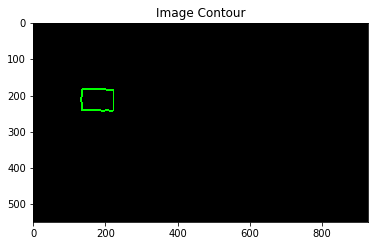

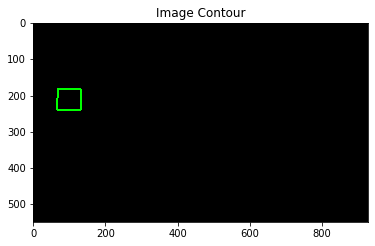

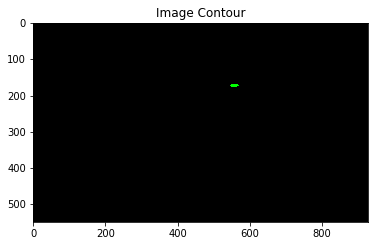

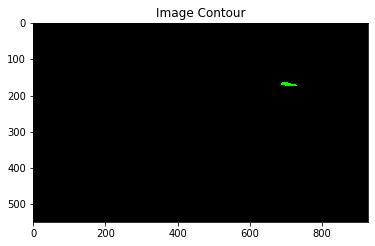

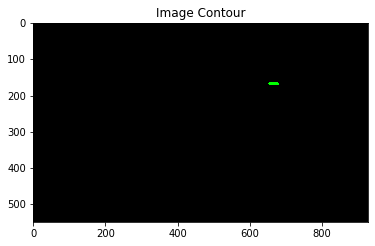

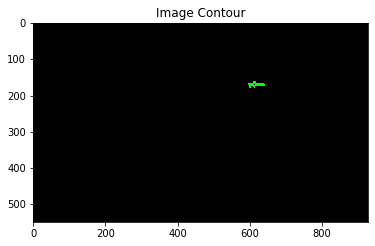

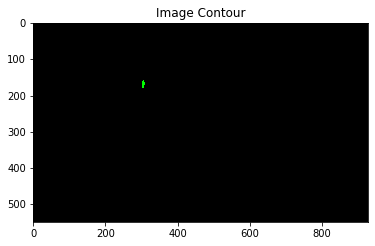

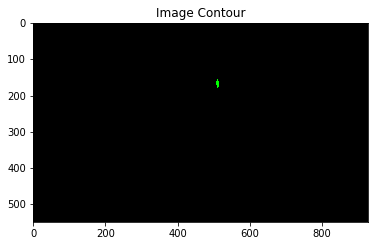

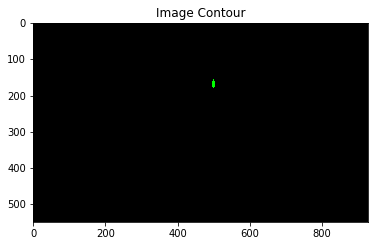

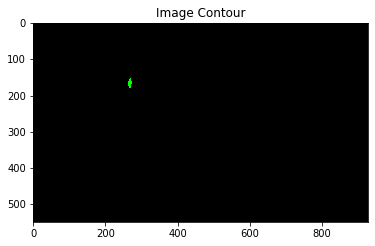

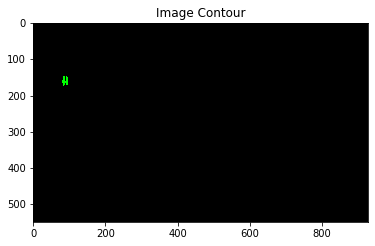

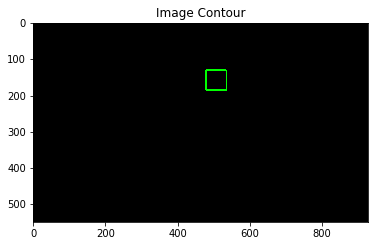

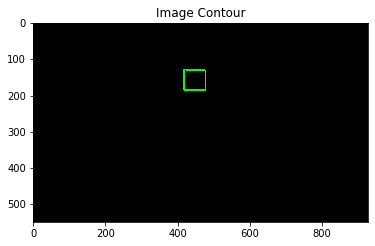

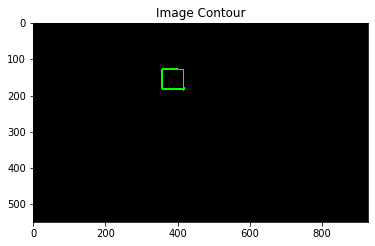

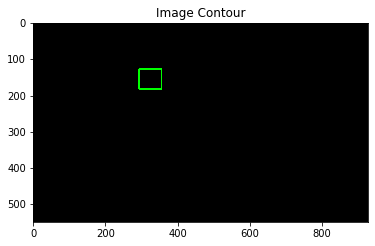

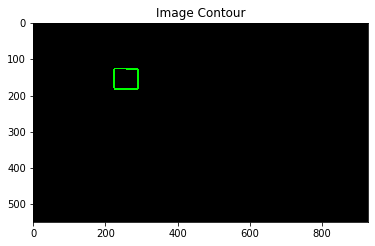

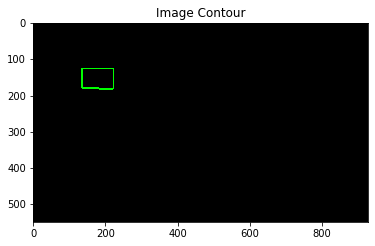

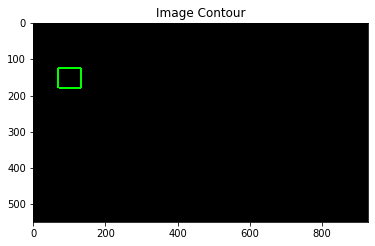

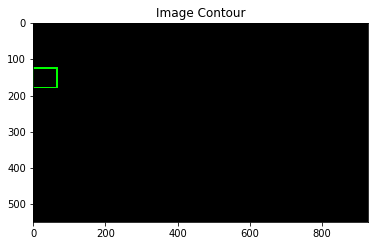

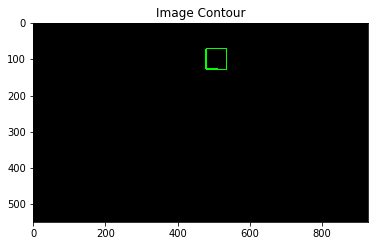

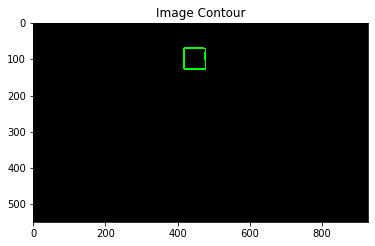

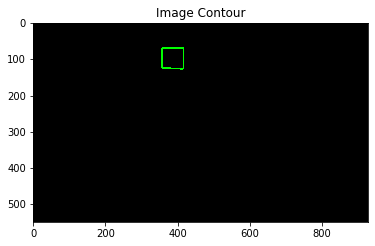

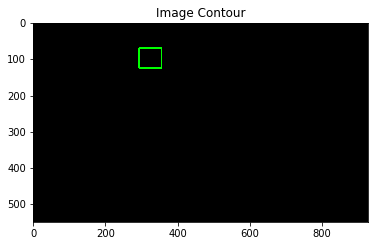

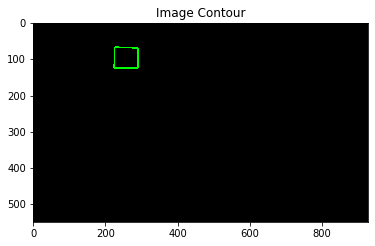

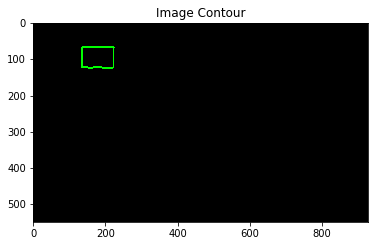

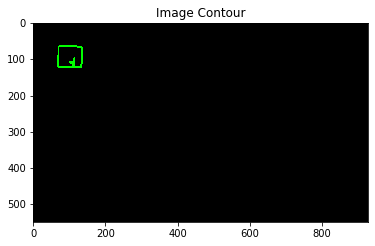

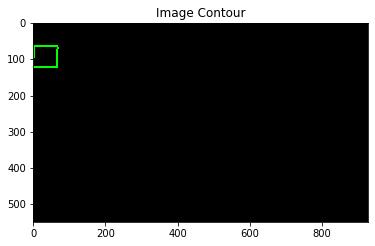

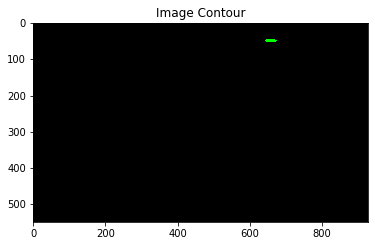

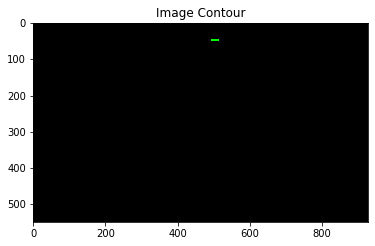

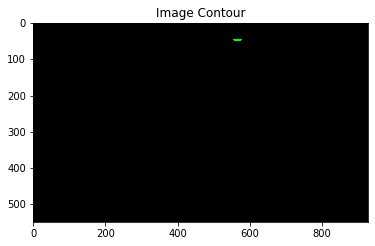

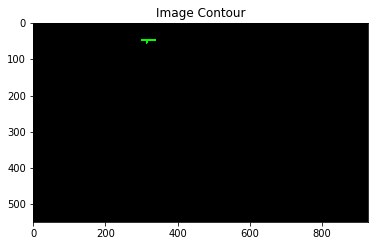

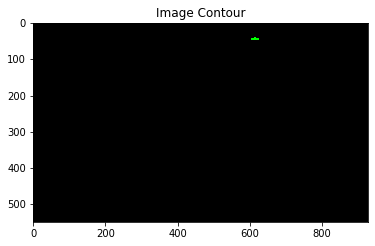

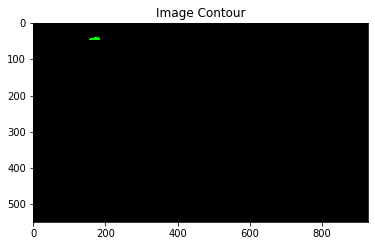

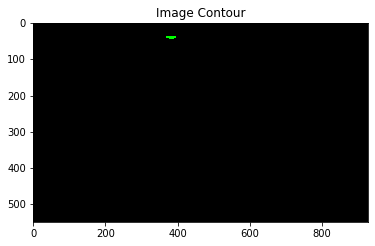

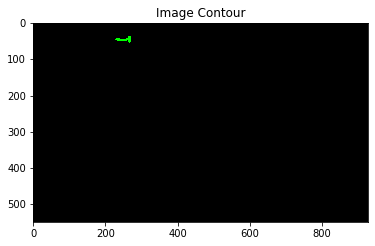

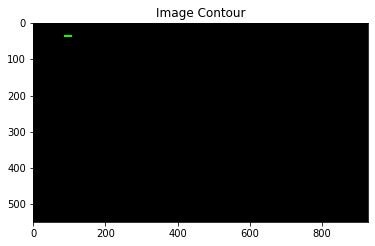

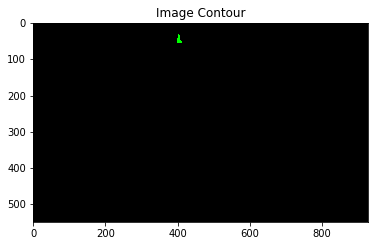

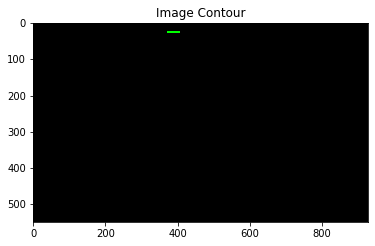

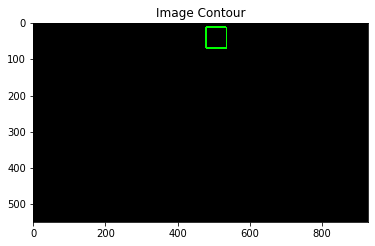

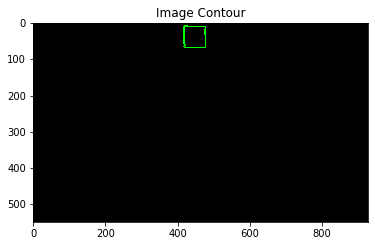

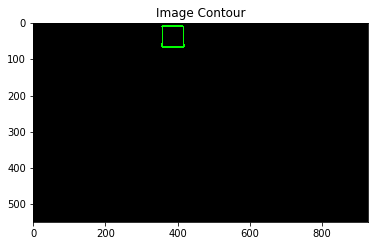

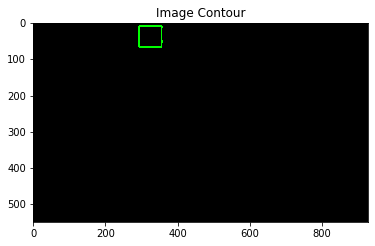

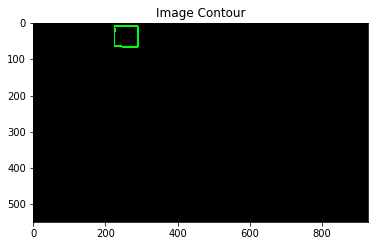

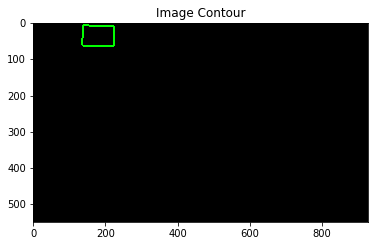

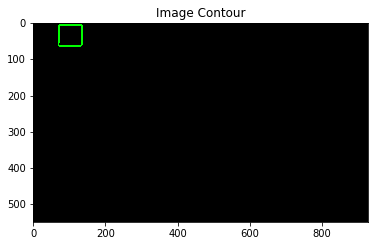

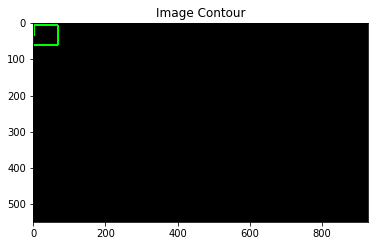

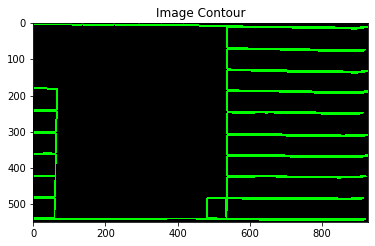

In [8]:
print("""Another option would be the detection of contours as they could represent the table lines. But again, this is not the case.
Some table cells are detected but as you can see in the last image some cells are merged in one contour.""")


def find_contours(img):
    # https://stackoverflow.com/questions/14184147/detect-lines-opencv-in-object
    img_8bit = np.uint8(img * 255)
    contours, _ = cv2.findContours(img_8bit, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    img_cleaned = np.zeros((img_8bit.shape[0], img_8bit.shape[1], 3), np.uint8)
    for cnt in contours:
        img_copy = img_cleaned.copy()
        cv2.drawContours(img_copy, [cnt], -1, (0,255,0), 3)
        show_image(img_copy, "Image Contour")
    
    return None


find_contours(img_cleaned_cc)

The best way to detect the lines properly is applying hough transformation on the equalized image.


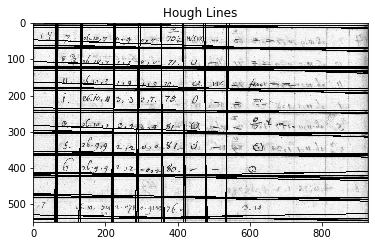

In [9]:
print("""The best way to detect the lines properly is applying hough transformation on the equalized image.""")


def get_hough_lines(img_edges, theta=np.pi/180):   
    img_edges = img_edges.astype(np.uint8)
    min_length = 300
    return cv2.HoughLines(img_edges, rho=1.25, theta=theta, threshold=min_length)


def filter_hough_lines(hough_lines):
    hough_lines_filtered = []
    for line in hough_lines:
        for rho, theta in line:
            # vertical lines
            if theta > (np.pi/180)*170 or theta < (np.pi/180)*10:
                hough_lines_filtered.append(line)
            
            # horizontal lines
            elif theta > (np.pi/180)*80 or theta < (np.pi/180)*100:
                hough_lines_filtered.append(line)
                
    return hough_lines_filtered


def _get_coordinates_of_hough_line(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000*(a))
    
    return x1, y1, x2, y2


def draw_hough_lines(img, hough_lines):
    img_hough_lines = img.copy()
    if hough_lines is not None:
        for line in hough_lines:
            for rho, theta in line:
                x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
                cv2.line(img_hough_lines, (x1,y1), (x2,y2), (0, 0, 255), 2)
    return img_hough_lines


"""
    For maximum accuracy you need a value of 180. To only detect even angles, theta should be 90
"""
hough_lines = get_hough_lines(img_cleaned_cc, np.pi/180)
hough_lines_filtered_by_orientation = filter_hough_lines(hough_lines)

img_hough_lines = draw_hough_lines(img_equalized.copy(), hough_lines_filtered_by_orientation)
show_image(img_hough_lines, "Hough Lines")

In [10]:
print("""As many lines are detected, there is a need to filter them.""")


def _get_line_points(img, P1, P2):
    """
    Produces an array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    # Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: 
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: 
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else:
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer


def get_parallel_line(x1, y1, x2, y2, offset):       
    l = math.sqrt((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2))

    x1_p = int(x1 + offset * (y2 - y1) / l)
    x2_p = int(x2 + offset * (y2 - y1) / l)
    y1_p = int(y1 + offset * (x1 - x2) / l)
    y2_p = int(y2 + offset * (x1 - x2) / l)
    
    return x1_p, y1_p, x2_p, y2_p


def get_avg_intensities(input_image, x1, y1, x2, y2):
    point_1 = np.array([x1, y1])
    point_2 = np.array([x2, y2])
    
    line_iterator = _get_line_points(input_image, point_1, point_2)
    
    intensities = np.array([line_point[2] for line_point in line_iterator])

    intensities_mean = np.mean(intensities)
    return intensities_mean


def compute_hisogram_of_avg_pixel_values(values):
    from scipy import stats
    
    bins = 255 // 15
    
    mean = np.average(values)
    
    """
    Mean is good enough.
    KDE can also be useful, but the result is the same.
    
    linespace = np.linspace(0, 255, 256)
    
    kde = stats.gaussian_kde(values, bw_method='scott')
    
    densities = kde(linespace)
    
    max_item = np.argmax(densities)
    
    print("KDE avg density is {}".format(max_item))
    
    plot, ax = plt.subplots(figsize=(8,6))
    ax.hist(values, density=True, bins=bins, alpha=0.3)
    ax.plot(linespace, kde(linespace))
    """
    
    return mean

As many lines are detected, there is a need to filter them.


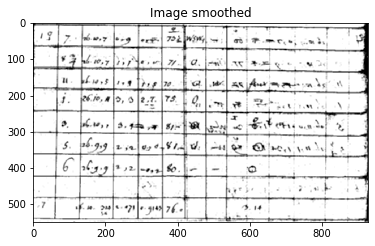

In [11]:
img_thresholded = binarize_image(img_equalized, otsu=False)

kernel = np.ones((5,5),np.float32) / 25
img_thresholded_smoothed = cv2.filter2D(img_thresholded, -1, kernel)

show_image(img_thresholded_smoothed, "Image smoothed")

In [12]:
filtered_hough_lines_img = img_equalized.copy()

avg_intensity_of_lines = []

for index, line in enumerate(hough_lines_filtered_by_orientation):
    for rho, theta in line:
        x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
        
        avg_intensity_of_line = get_avg_intensities(img_thresholded_smoothed, x1, y1, x2, y2)
        avg_intensity_of_lines.append(avg_intensity_of_line)
        
        for i in range(-2, 3):
            offset = i
            
            if offset == 0:
                continue
            
            x1_p, y1_p, x2_p, y2_p = get_parallel_line(x1, y1, x2, y2, offset)
        
            avg_intensity_of_line = get_avg_intensities(img_thresholded_smoothed, x1_p, y1_p, x2_p, y2_p)
            avg_intensity_of_lines.append(avg_intensity_of_line)


avg_intensity_of_lines = np.array(avg_intensity_of_lines)

lines_hough_threshold = compute_hisogram_of_avg_pixel_values(avg_intensity_of_lines)

hough_lines_filtered_by_intensity = []

for index, line in enumerate(hough_lines_filtered_by_orientation):
    for rho, theta in line:       
        x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
        
        for i in range(-2, 3):           
            x1_p, y1_p, x2_p, y2_p = get_parallel_line(x1, y1, x2, y2, i)
            
            avg_intensity_of_line = get_avg_intensities(img_thresholded_smoothed, x1_p, y1_p, x2_p, y2_p)

            if avg_intensity_of_line < int(lines_hough_threshold):
                hough_lines_filtered_by_intensity.append(np.array([[rho, theta]]))
                cv2.line(filtered_hough_lines_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                
                break
        
                       
hough_lines_filtered_by_intensity = np.array(hough_lines_filtered_by_intensity)

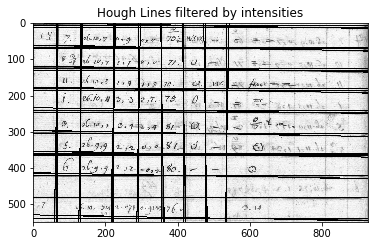

In [13]:
img_hough_lines = draw_hough_lines(img_equalized.copy(), hough_lines_filtered_by_intensity)
show_image(img_hough_lines, "Hough Lines filtered by intensities")

In [14]:
# TODO: Group close lines (hough_lines_filtered_by_intensity)

In [15]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    angles = np.array([line[0][1] for line in lines])

    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  
    
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
        
    segmented = list(segmented.values())
    
    return segmented

In [26]:
# TODO: Group close lines (hough_lines_filtered_by_intensity)

def distance_between_points(P1, P2):
    dist = math.sqrt((P2[0] - P1[0])**2 + (P2[1] - P1[1])**2)
    return dist

def length_of_line(line):
    return distance_between_points(line[0], line[1])

def do_intersect(lista, listb):
    return bool(set(lista)&set(listb))

hough_lines_segmented = segment_by_angle_kmeans(hough_lines_filtered_by_intensity)

hough_lines_horizontal = hough_lines_segmented[0]
hough_lines_vertical = hough_lines_segmented[1]

lines_horizontal_cart = []
lines_vertical_cart = []

for line in hough_lines_horizontal:
    for rho, theta in line:
        x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
        lines_horizontal_cart.append([[x1, y1], [x2, y2]])
        # print(f"{line_points[0][0]} {line_points[0][1]}, {line_points[1][0]} {line_points[1][1]}")
        
for line in hough_lines_vertical:
    for rho, theta in line:
        x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
        line_points = [(x1,y1),(x2,y2)]
        if y1 > y2:
            line_points[0], line_points[1] = line_points[1], line_points[0] 
        lines_vertical_cart.append(line_points)
        # print(f"{line_points[0][0]} {line_points[0][1]}, {line_points[1][0]} {line_points[1][1]}")


dbscan = cluster.DBSCAN(metric=hausdorff_distance, eps=3, min_samples=2)
dbscan.fit(lines_horizontal_cart)
# labels_

"""
proximities_horizontal = []
for i in range(0, len(lines_horizontal_cart) - 1):
    for j in range(i + 1, len(lines_horizontal_cart)):
        line_i = lines_horizontal_cart[i]
        line_j = lines_horizontal_cart[j]
        line_i_length = length_of_line(line_i)
        line_j_length = length_of_line(line_j)
        ls = line_i_length if line_i_length < line_j_length else line_j_length 
        
        dstart = distance_between_points(line_i[0], line_j[0])
        dend = distance_between_points(line_i[1], line_j[1])
        g = dstart if dstart < dend else dend
        
        proximity = (ls/g)**2
        
        # print(f"{proximity}")
        
        proximities_horizontal.append([(i, j), proximity])

proximities_horizontal = sorted(proximities_horizontal, key=lambda el: el[1], reverse=True)
# print(f"{proximities_horizontal}")

threshold_p = 0
proximities_horizontal = [proximity for proximity in proximities_horizontal if proximity[1] > threshold_p]
print(f"{proximities_horizontal}")

groups_horizontal = []        
for line_pair in proximities_horizontal:
    should_new_group_be_added = True
    for group_horizontal in groups_horizontal:
        if do_intersect(line_pair[0], group_horizontal):
            group_horizontal.extend(line_pair[0])
            should_new_group_be_added = False
            break
    if should_new_group_be_added:
        groups_horizontal.append([line_index for line_index in line_pair[0]])

groups_horizontal_unique = []
for group_horizontal in groups_horizontal:
    groups_horizontal_unique.append(set(group_horizontal))
    
print(f"{groups_horizontal_unique}")
"""

ValueError: Found array with dim 3. Estimator expected <= 2.

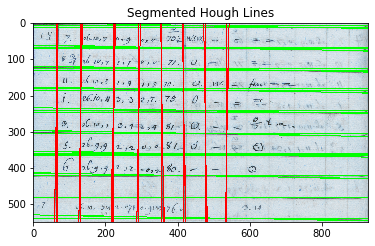

In [17]:
hough_lines_segmented = segment_by_angle_kmeans(hough_lines_filtered_by_intensity)

hough_lines_segmented_img = img_og.copy()

for index, item in enumerate(hough_lines_segmented):
    color = None
    if index == 0:
        color = (0, 255, 0)
        # Group horizontal lines according to their Proximity/ Collinearity
    else:
        color = (255, 0, 0)
        # Group vertical lines according to their Proximity/ Collinearity
    for line in item:
        for rho, theta in line:
            x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
            cv2.line(hough_lines_segmented_img, (x1, y1), (x2, y2), color, 2)
            
show_image(hough_lines_segmented_img, 'Segmented Hough Lines')

Althouhg the hough lines get filtered, there are still more intersections than neccessary.


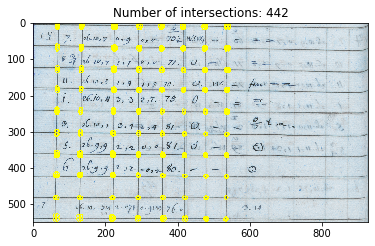

In [18]:
print("""Althouhg the hough lines get filtered, there are still more intersections than neccessary.""")


intersections_img = img_og.copy()

def _get_intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]  # [[]]


def get_segmented_intersections(lines):
    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(_get_intersection(line1, line2)) 

    return intersections


intersections = np.array(get_segmented_intersections(hough_lines_segmented))
intersections = np.reshape(intersections, (intersections.shape[0], intersections.shape[2]))

for intersection in intersections:
    cv2.circle(intersections_img, (intersection[0], intersection[1]), 5, (255, 255, 0), 2)
    
show_image(intersections_img, 'Number of intersections: {}'.format(intersections.shape[0]))

Because of this the intersection points are clustered.


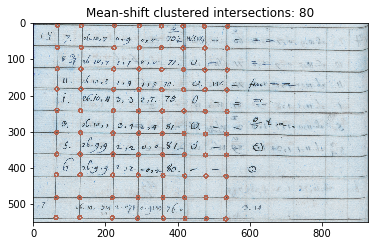

Based on the points table cells can extracted and fed to OCR.


In [19]:
print("""Because of this the intersection points are clustered.""")


cluster_points_mean_shift_img = img_og.copy()

number_of_samples = intersections.shape[0]
bandwidth = cluster.estimate_bandwidth(intersections, quantile=0.0175, n_samples=number_of_samples)

mean_shift = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
mean_shift.fit(intersections)

labels_mean_shift = mean_shift.labels_
labels_mean_shift = np.unique(labels_mean_shift)

table_intersections = mean_shift.cluster_centers_

for point in table_intersections:
    cv2.circle(cluster_points_mean_shift_img, (int(point[0]), int(point[1])), 5, (180, 100, 80), 4)
    
show_image(cluster_points_mean_shift_img, 'Mean-shift clustered intersections: {}'.format(len(labels_mean_shift)))


print("""Based on the points table cells can extracted and fed to OCR.""")